## Imports

In [100]:
import json
import joblib
import shap
import pandas as pd
import sys
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../"))
from src.utils import load_train_test_data

### Load pipeline and data

In [101]:
pipeline = joblib.load("../data/models/final_pipeline.pkl")

with open("../params.yaml", "r") as file:
    params = yaml.safe_load(file)

with open("../data/models/best_features.json", "r") as f:
    best_features = json.load(f)["best_features"]

In [102]:
pipeline[0].verbose_feature_names_out = True

In [134]:
_, test_data = load_train_test_data("../data/train_test_data")
test_data = test_data[params["features"]["selected"]]

if best_features == "text":
    test_data = test_data.drop(
        columns=params["features"]["numerical"] + params["features"]["categorical"],
        errors="ignore",
    )
elif best_features == "non-text":
    test_data = test_data.drop(columns=params["features"]["text"], errors="ignore")

X = test_data.drop(columns=params["split_data"]["label_column"])
y = test_data[params["split_data"]["label_column"]]

2025-04-13 20:57:41 - INFO - Loading train and test data


### Init explainer and shap_values

In [104]:
shap.initjs()
X_transformed = pipeline.named_steps["preprocessor"].transform(X)

if not isinstance(X_transformed, np.ndarray):
    X_transformed = X_transformed.toarray()

In [55]:
explainer = shap.TreeExplainer(pipeline.named_steps["classifier"])
shap_values = explainer.shap_values(X_transformed, approximate=True)

In [66]:
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

### Summary plot

Wykres ukazuje, iż najbarzdiej wpływowym wyrazem okazało się "love" w "text review". Wyraz ten zwiększał sharp value dla ratingu równego 5 o wartość aż 0.08

Kolejnym popularnym wyrazem okazało się "amazing" w  "review_text", które bardzo znacząco wpływało na wystąpienie zdania z tym wyrazem na przynależność do klasy rating = 5 lub 4.

Na trzecim miejscu znalazł się wyraz "like" w review, który ponownie znacząco zwiększał szanse zdania na przynależenie do najwyższych ocen.

Pozostałymi ciekawymi wyrazami okazało się być "bad" oraz "return", ponieważ znacząco zwiększają prawdopodobieństwo recenzji do znajdowania się w wartości rating 1-2.

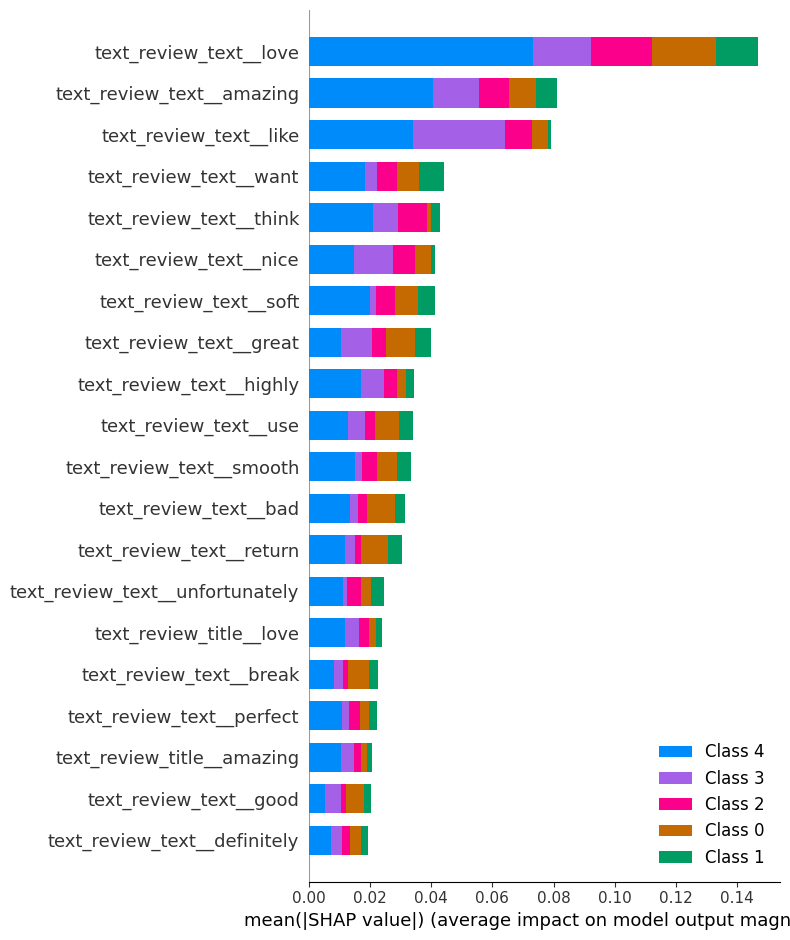

In [68]:
shap.summary_plot(shap_values, X_transformed_df, plot_type="bar")

### Summary plot Rating 1

Dla rating = 1 wyrazami o największej sile pchania w jedną ze stron okazało się być:
- bad - znacząco wartość 1 wpływa na przynależność do rating = 1 w znaczący sposób (0.2-0.4 impact)

Podobnie wyrazy

- return
- break
- unfortunatelly

Z kolei kilka wyrazów odpychało zdanie od klasy 1 takich jak:
- love
- great
- help
- soft
- smooth

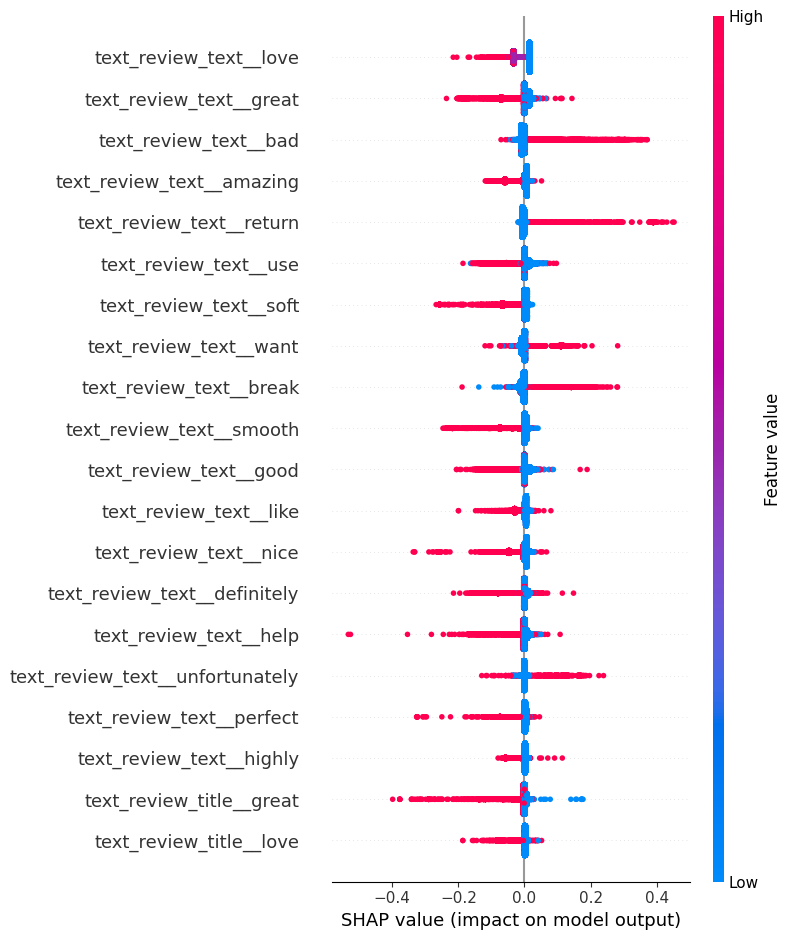

In [113]:
shap.summary_plot(shap_values[:, :, 0], X_transformed_df)

### Summary plot Rating 2

Dla rating = 2 wyrazami o największej sile pchania w jedną ze stron okazało się być:
- return - znacząco wartość 1 wpływa na przynależność do rating = 1  o 0.1 do 0.3 impact score

Podobnie wyrazy

- want
- bad
- unfortunatelly

Z kolei kilka wyrazów odpychało zdanie od klasy 1 takich jak:
- perfect
- great
- smooth
- soft

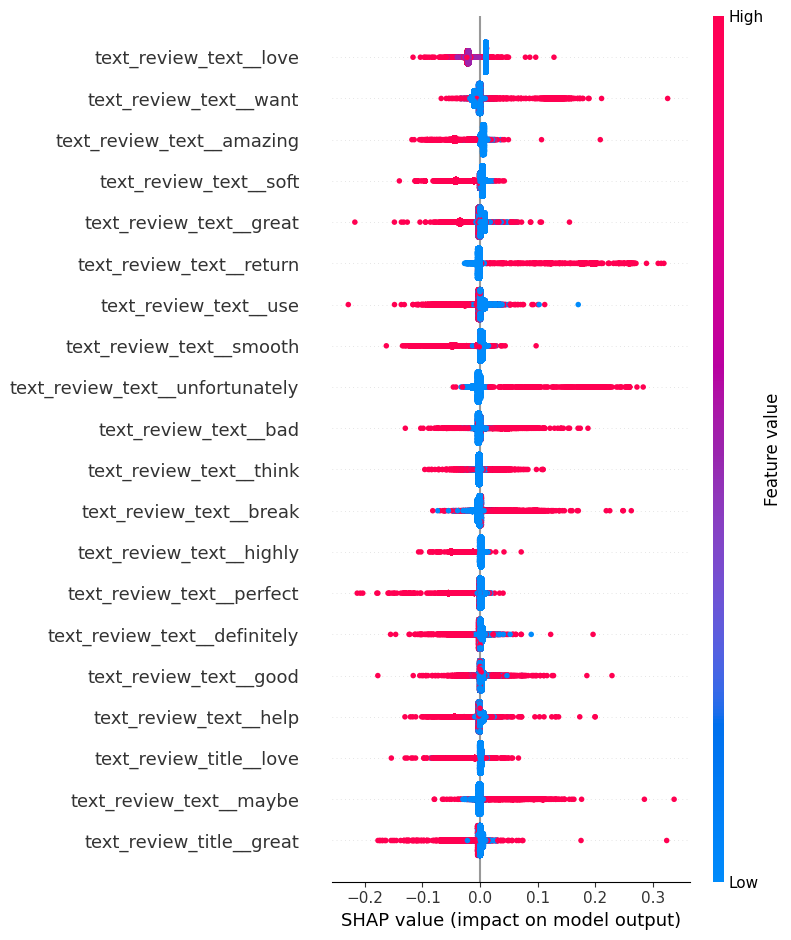

In [114]:
shap.summary_plot(shap_values[:, :, 1], X_transformed_df)

### Summary plot Rating 3

Dla rating = 3 wyrazami o największej sile pchania w jedną ze stron okazało się być:
- ok oraz okay - znacząco wartość 1 wpływa na przynależność do rating = 1 w **zdecydowany sposób, aż 0.3-0.6**

Podobnie wyrazy

- maybe
- unfortunatelly

Z kolei kilka wyrazów odpychało zdanie od klasy 1 takich jak:
- definitely
- amazing
- perfect
- great

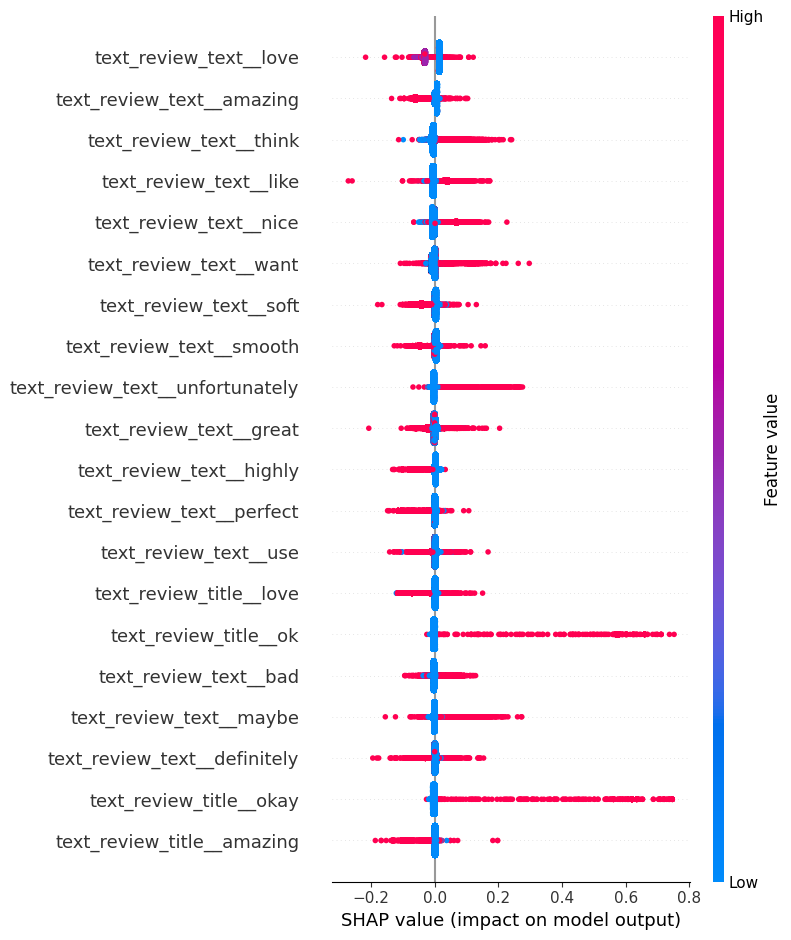

In [112]:
shap.summary_plot(shap_values[:, :, 2], X_transformed_df)

### Summary plot Rating 4

Dla rating = 4 wyrazami o największej sile pchania w jedną ze stron okazało się być:
- like - znacząco wartość 1 wpływa na przynależność do rating = 1 w znaczący sposób (0.2-0.4 impact)

Podobnie wyrazy

- good
- enjoy
- wish

Z kolei kilka wyrazów odpychało zdanie od klasy 1 takich jak:
- highly
- amazing
- love

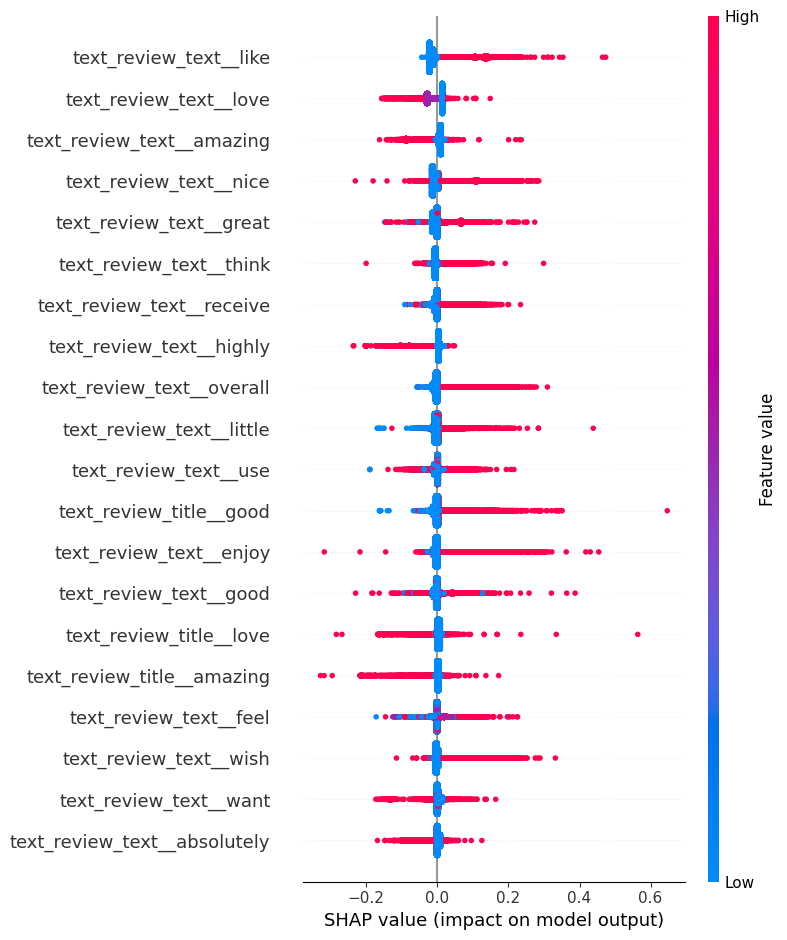

In [115]:
shap.summary_plot(shap_values[:, :, 3], X_transformed_df)

### Summary plot Rating 5

Dla rating = 5 wyrazami o największej sile pchania w jedną ze stron okazało się być:
- amazing - znacząco wartość 1 wpływa na przynależność do rating = 1 w znaczący sposób (0.2-0.4 impact)

Podobnie wyrazy

- perfect
- highly

Z kolei kilka wyrazów odpychało zdanie od klasy 1 takich jak:
- want
- return
- unfortunately
- break

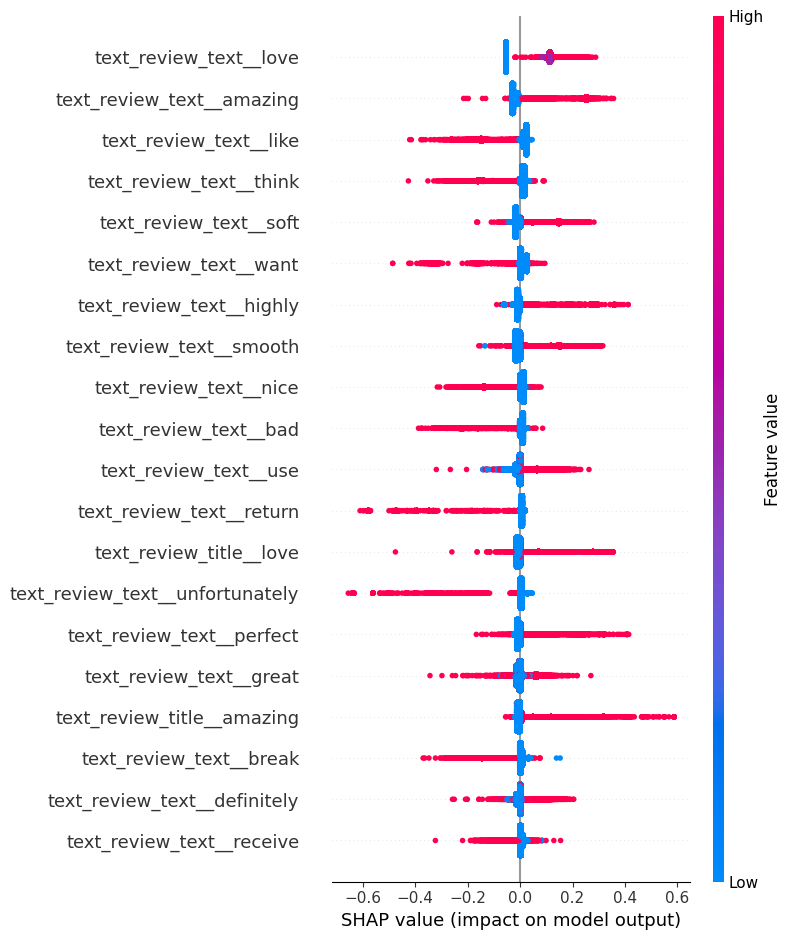

In [116]:
shap.summary_plot(shap_values[:, :, 4], X_transformed_df)

### Force plot for chosen sentence for each class

Dla przykładowego zdania oraz każdej klasy odnaleziono kilka wyrazów które zadecydowały o prawdopodobieństwie jego przynależenia do danego ratingu.

Dla rating 1 :
- love=1 oraz amazing=1 wraz z want=0 zadecydowały o zerowym prawdopodobieństwie, że zdanie ocenia produkt na 1/5

Dla rating 2:
- dokładnie ten sam powód zerwego prawd. do klasy 2/5

Dla rating 3:
- small=2, start=2, purchase=1, combo=2 pchały zdanie do ratingu 3 w znaczny sposób, lecz love=1 oraz amazing=1 spowodowały że finalne prawdopodobieństwo dla oceny 3/5 wyniosło 11%

Dla ratingu 4:
- great=2, overall=1, purchase=1 bardzo silnie zadecydowały o przynależeniu do wysokiej oceny, lecz try=1 oraz amazing=1 minimalnie zepchały zdanie na niższe prawdopodobieństwo przynależenia do klasy 4/5 dając finalnie 52%

Dla ratingu 5:
- love=1 i amazing=1 nie przezwyciężyło overall=1 great=2 oraz purchase=1, które po zsumowaniu dały prawd. przynależenia do klasy 5/5 równe 37%

Class 0


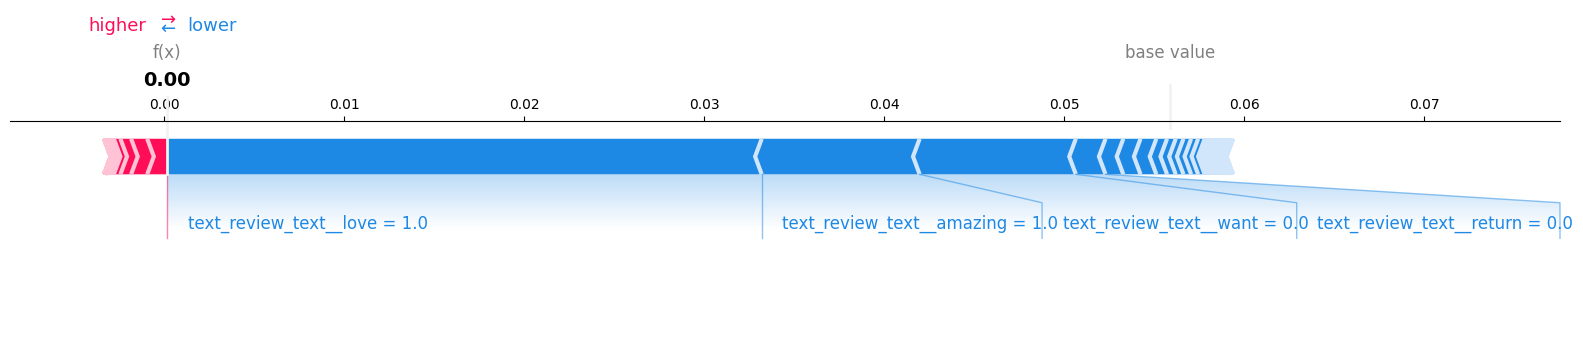

Class 1


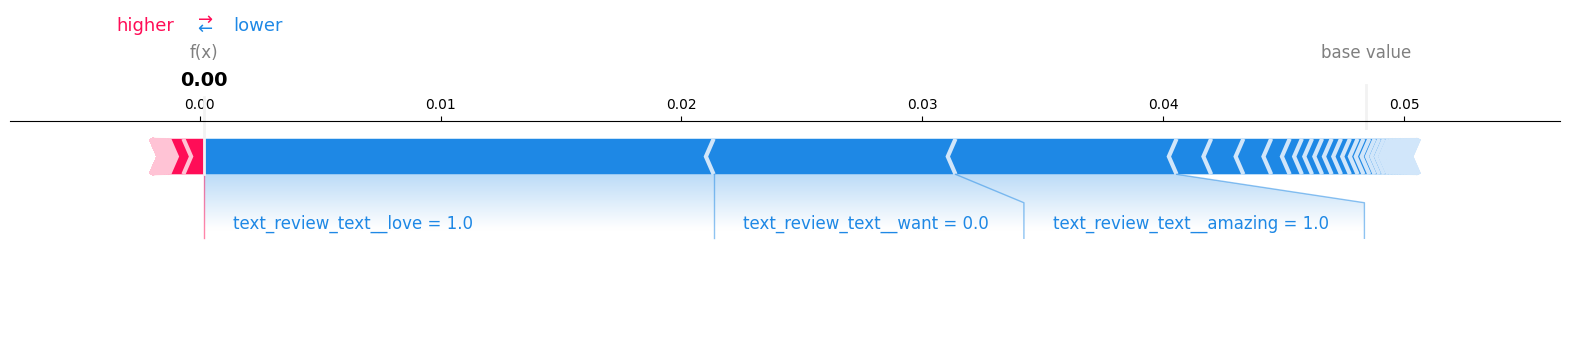

Class 2


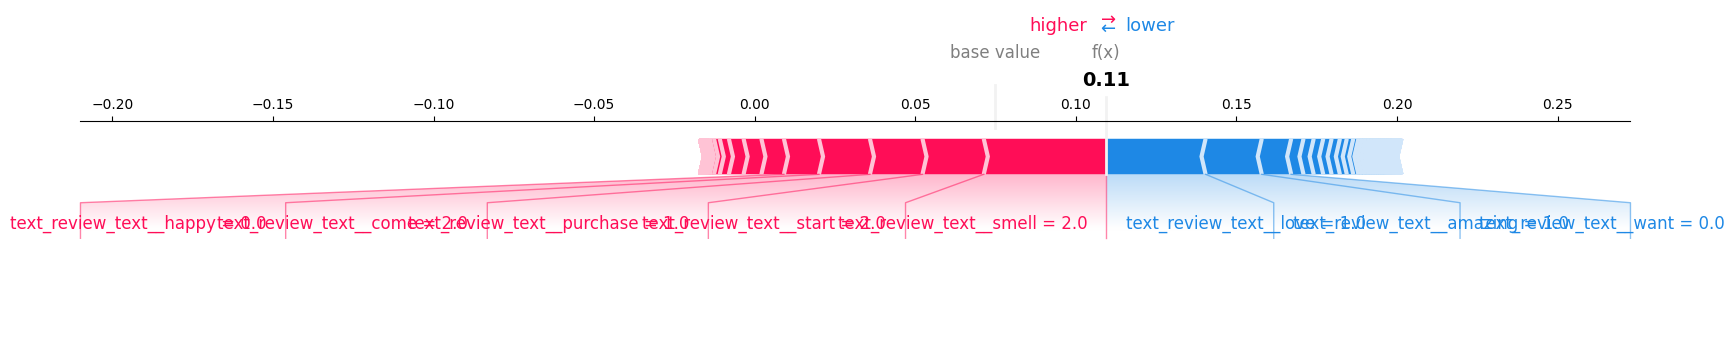

Class 3


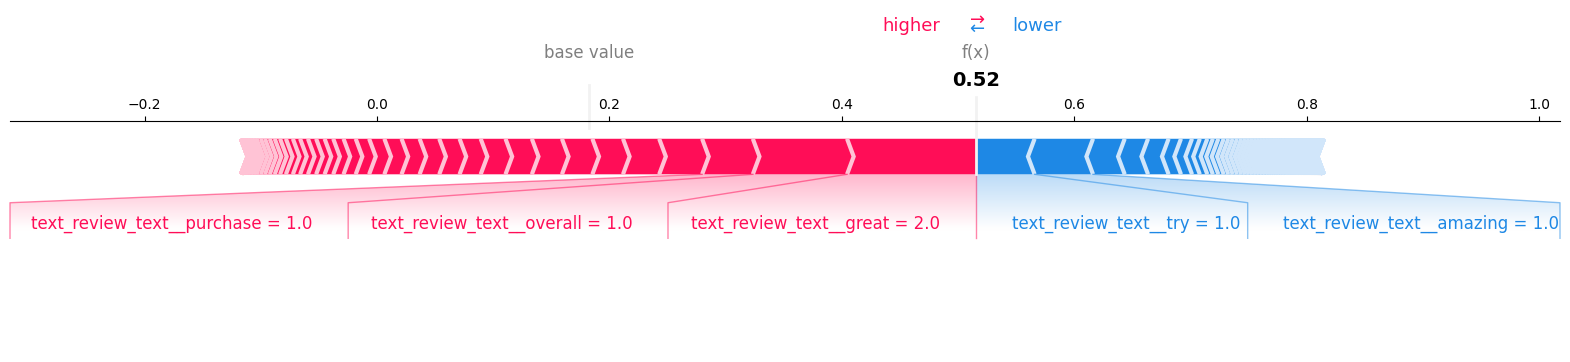

Class 4


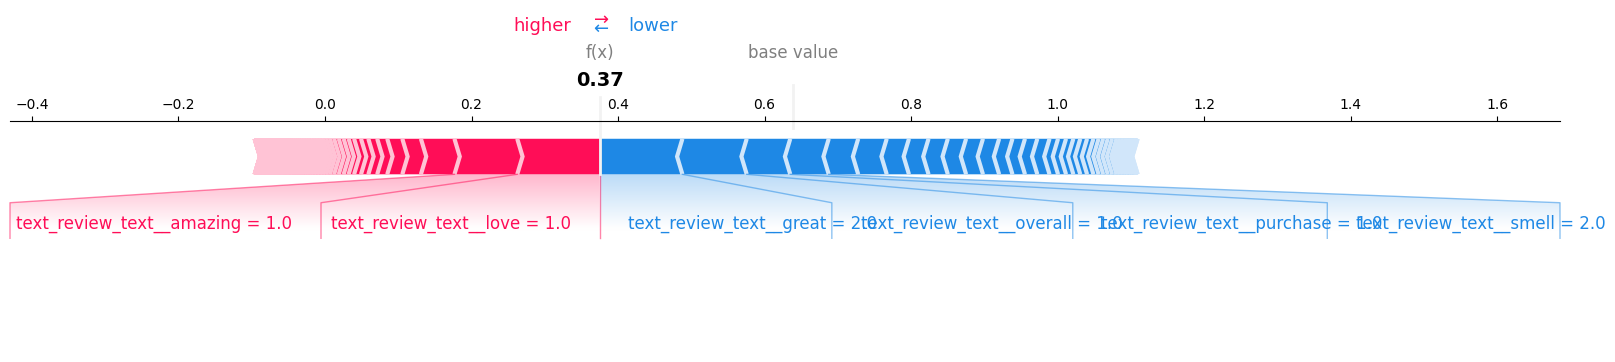

In [109]:
sample_idx = 12

for i in range(shap_values.shape[2]):
    print(f"Class {i}")
    shap.force_plot(
        explainer.expected_value[i],
        shap_values[sample_idx, :, i],
        X_transformed_df.iloc[sample_idx],
        matplotlib=True,
    )

### Force plot for 3 missclassified records

Analiza nieprawidłowo przewidzianych labeli ukazuje z jak wysoką pewnością model wystawia oceny 5/5 w zależności od podanego zdania.

Przeanalizowano 3 przykłady, gdzie w każdym model oszacował ocenę na 5/5, gdzie prawdziwe wynosiły kolejno 4/5, 3/5 oraz 1/5.

Dla 4/5 model był bardzo bliski odgadnięcia, gdyż ta ocena miała drgi najwyższy wskaźnik tuż po 5/5, lecz o losie przypisania najwyższej oceny zdecydowały wyraz "clear", który jest szacowany na bardzo znaczący przy ocenach 5/5

Dla 3/5 model był bardzo daleki od prawdy. Praw., że ta ocena otrzyma 3/5 było najniższe i kolejnym zdaniem modelu po 5/5 byłoby 4/5, następnie 1/5. Spowodowane jest to brakiem wystąpienia jakichkolwiek charaktetystyczych wyrazów dla vectorizera

Dla 1/5 model kompletnie nie przewidywał labela 1/5 ze względu na wystąpienie wyrazu "love".

Sample 163875 — True: 4.0, Pred: 5.0


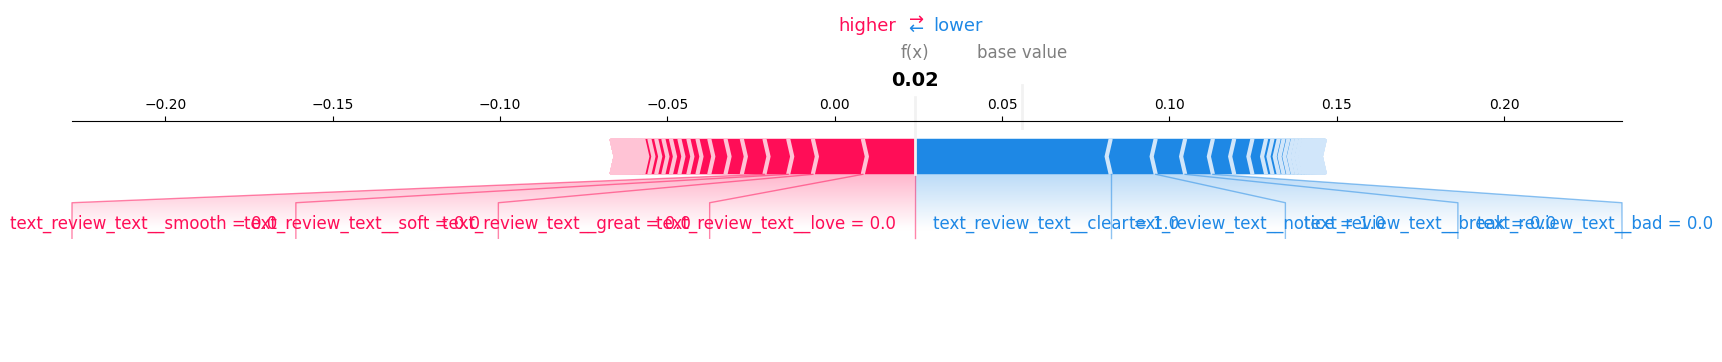

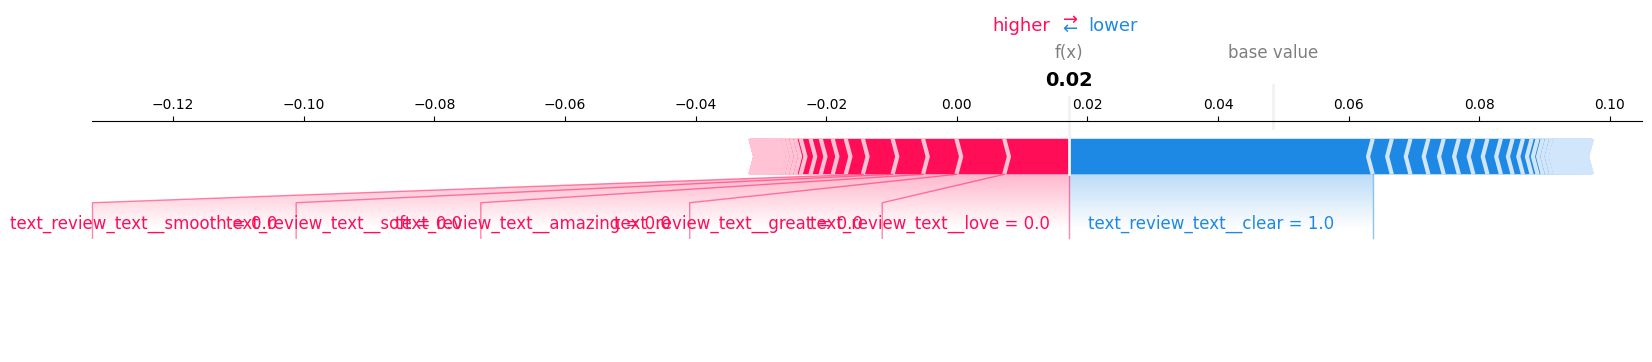

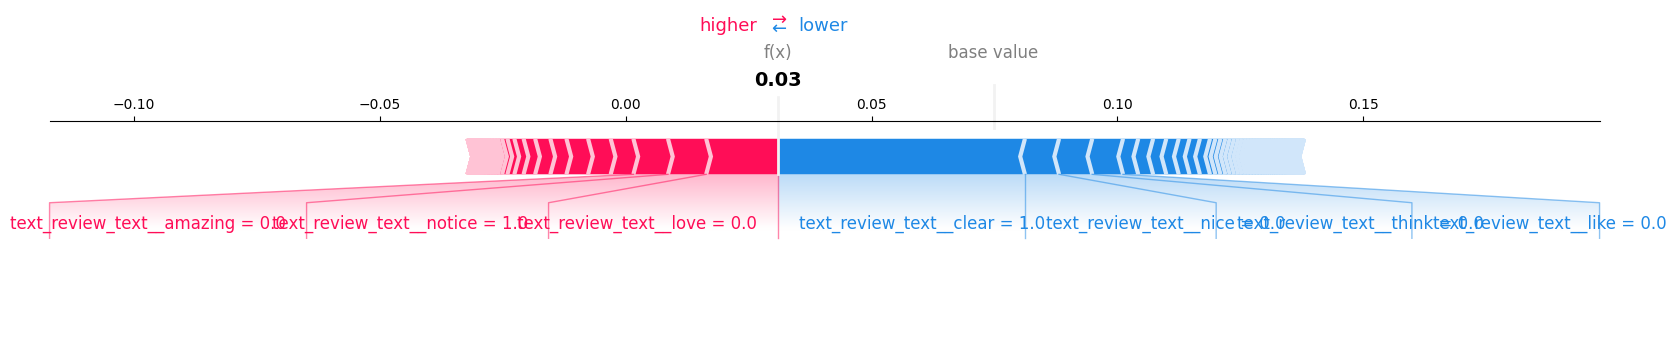

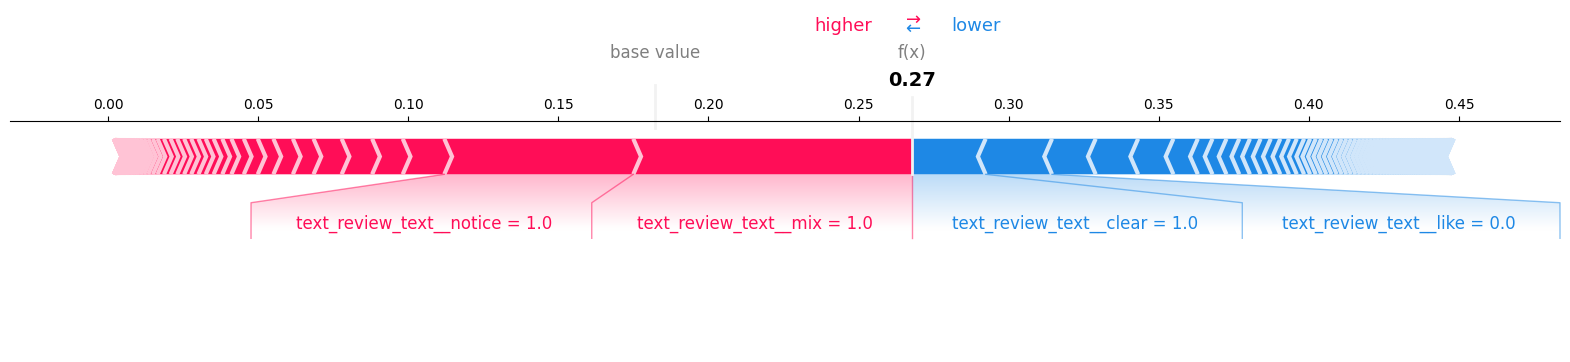

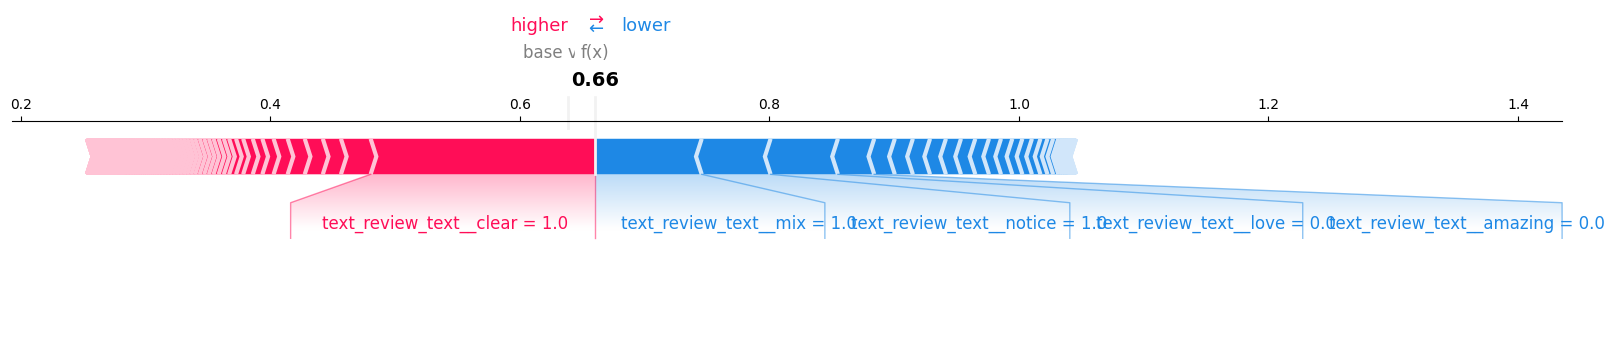

Sample 163876 — True: 3.0, Pred: 5.0


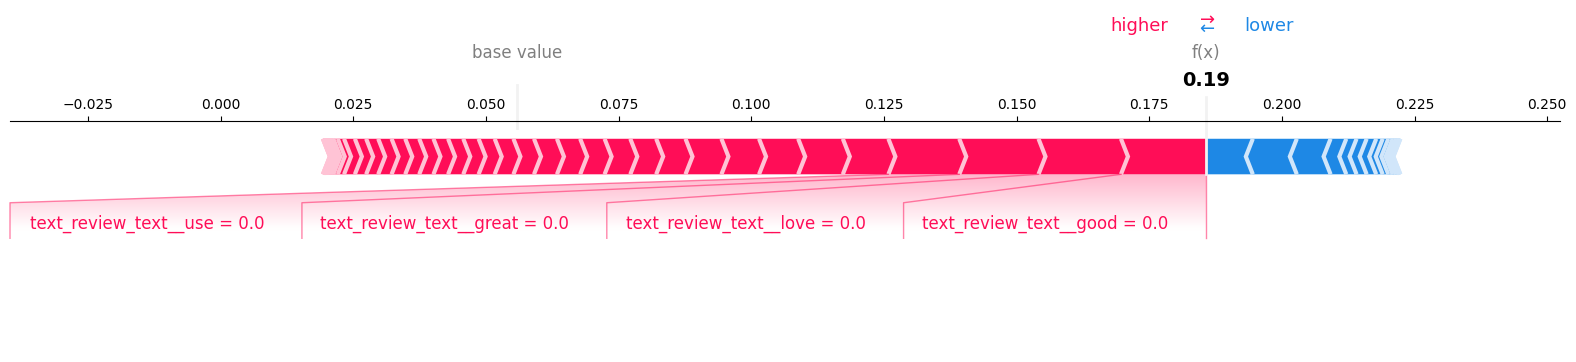

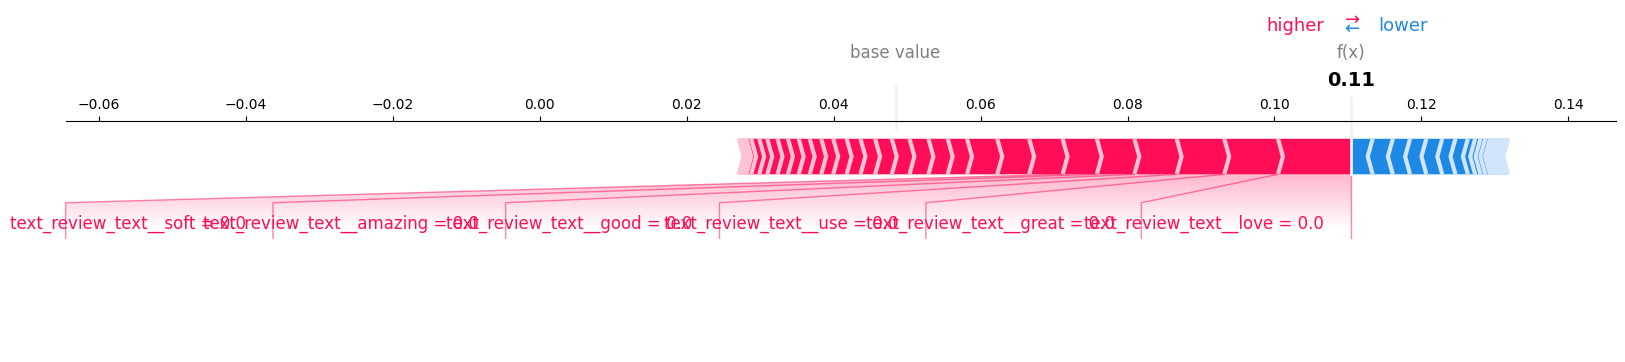

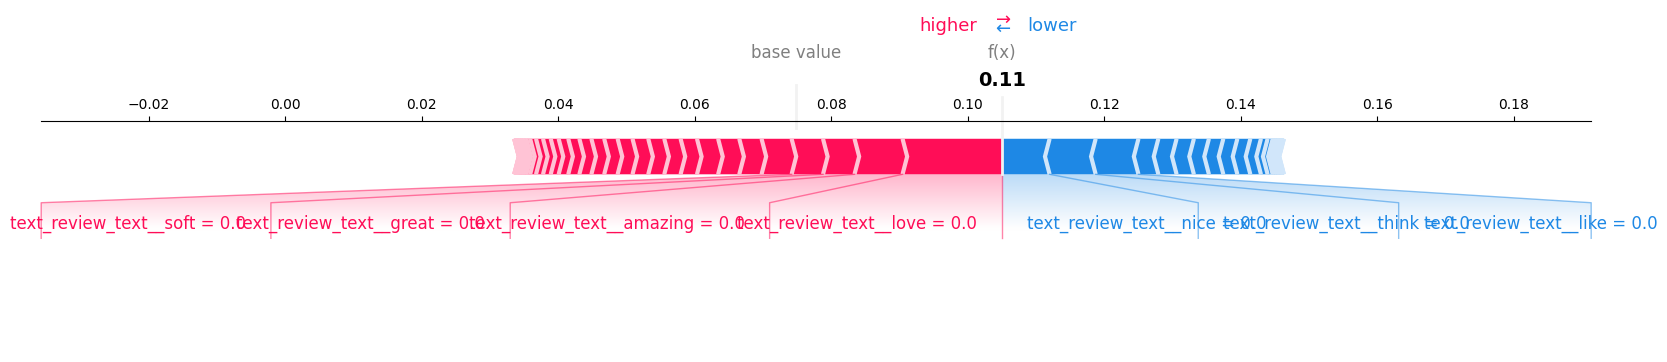

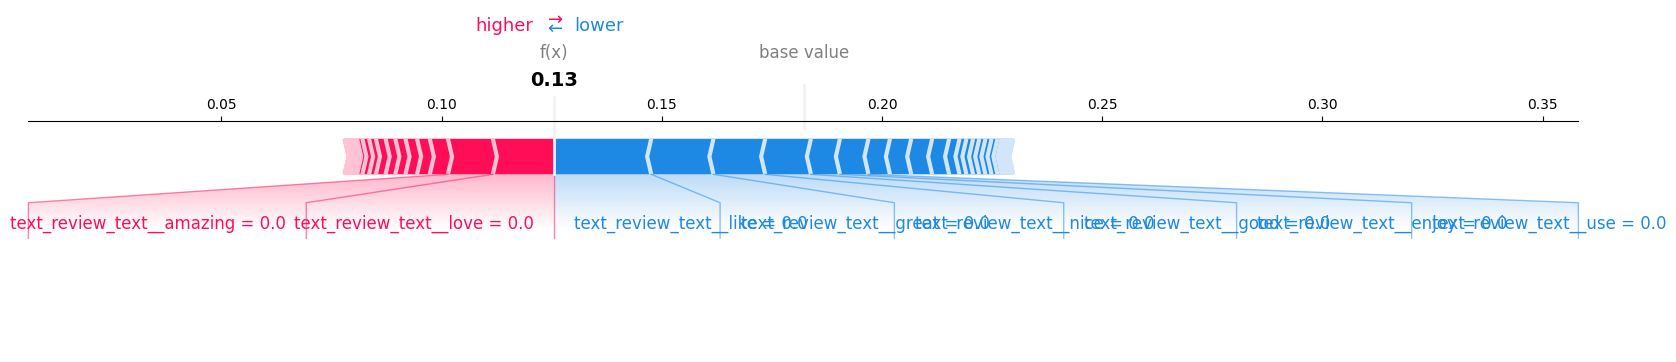

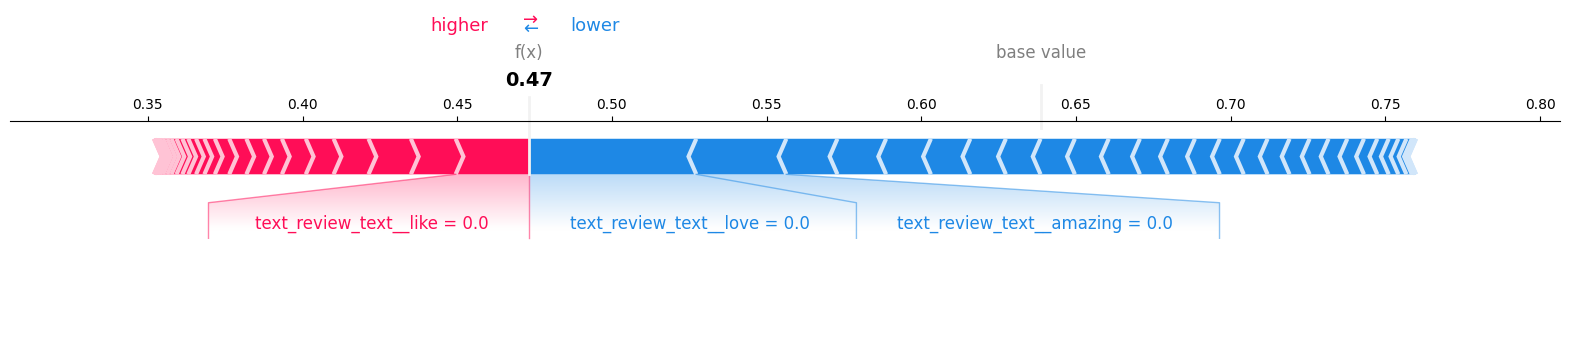

Sample 163878 — True: 1.0, Pred: 5.0


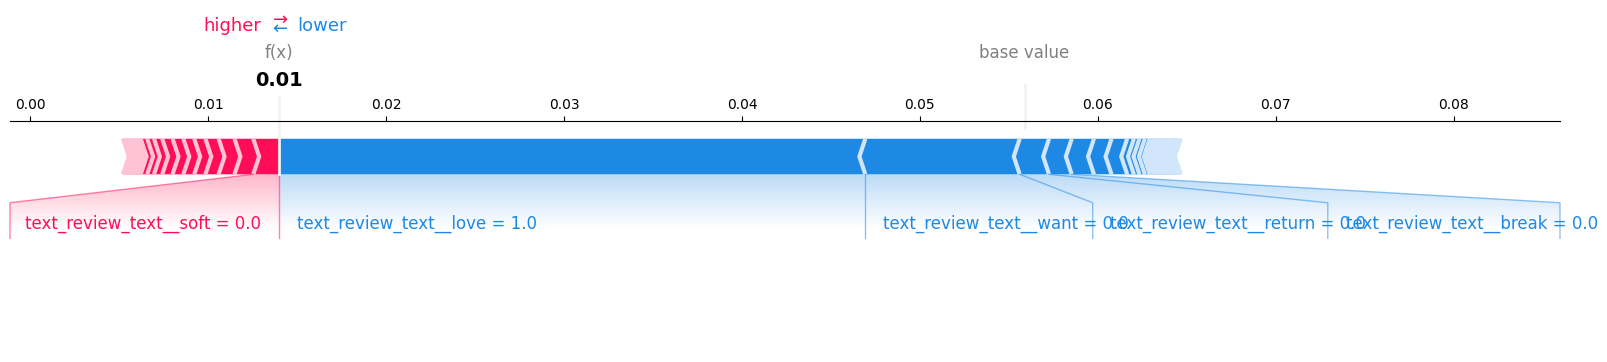

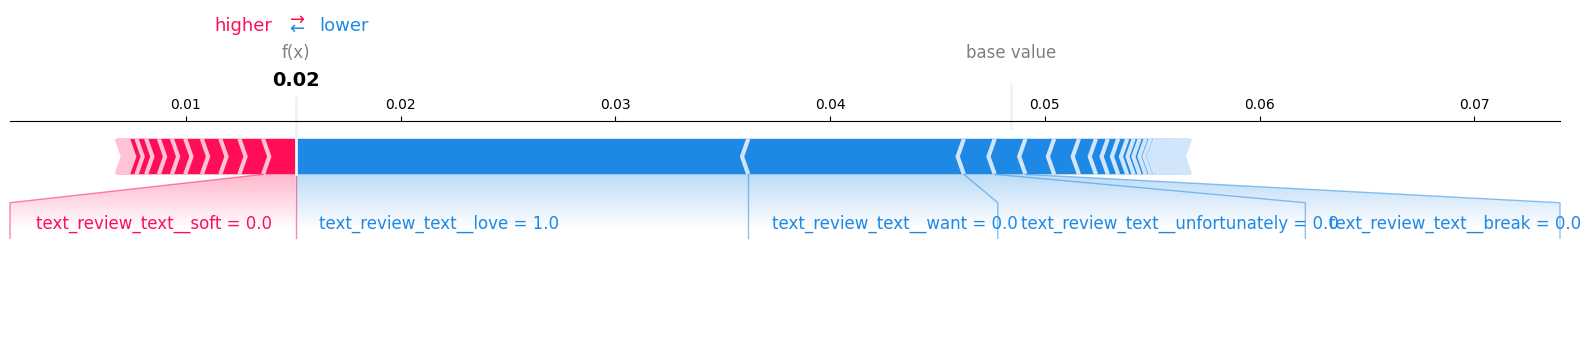

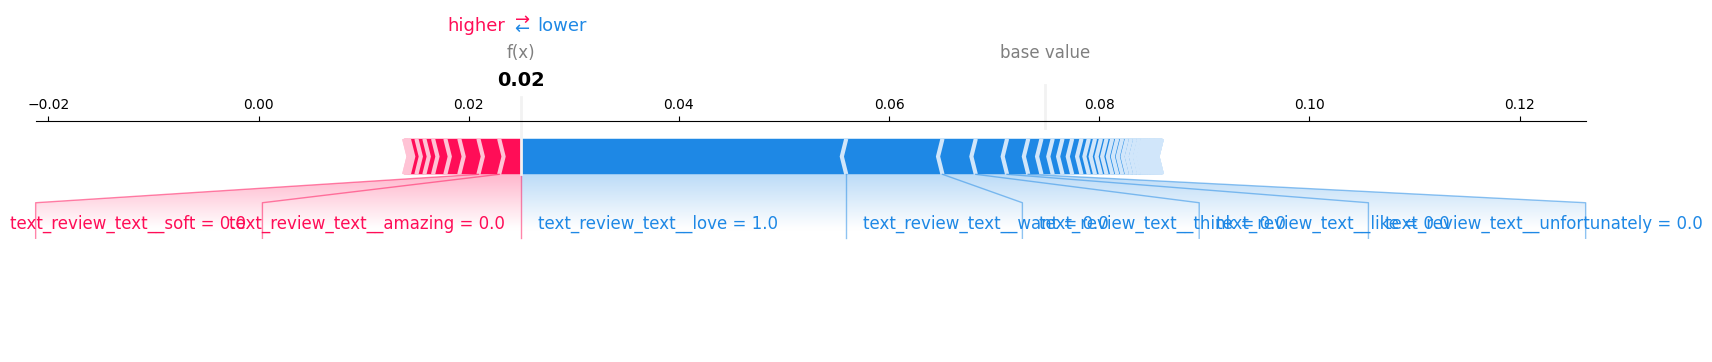

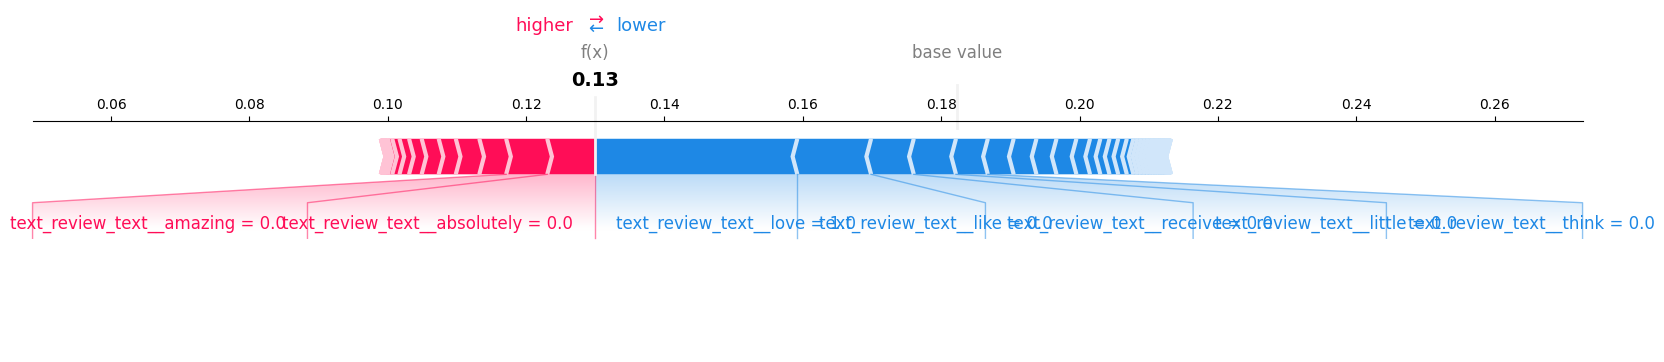

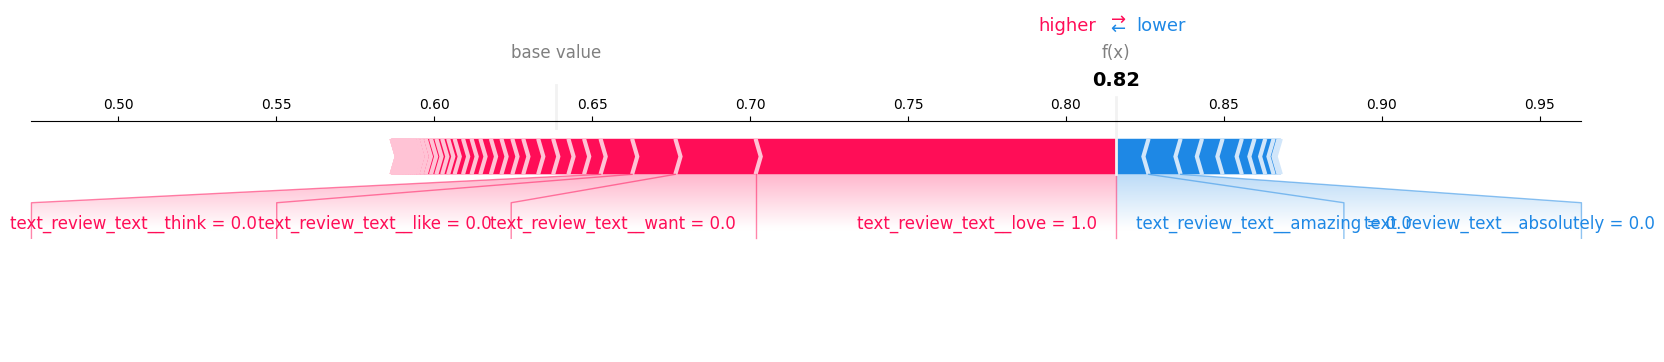

In [135]:
y_pred = pipeline.predict(X)

misclassified_idxs = np.where(y_pred != y)[0]

for sample_idx in misclassified_idxs[-3:]:
    print(
        f"Sample {sample_idx} — True: {y.iloc[sample_idx]}, Pred: {y_pred[sample_idx]}"
    )

    for class_id in range(shap_values.shape[2]):
        shap.force_plot(
            explainer.expected_value[class_id],
            shap_values[sample_idx, :, class_id],
            X_transformed_df.iloc[sample_idx],
            matplotlib=True,
        )